In [27]:
# Clone the GitHub repository
# !git clone https://github.com/yang-gwon2/ai_system_project_group8.git

Cloning into 'ai_system_project_group8'...
remote: Enumerating objects: 7475, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 7475 (delta 7), reused 26 (delta 5), pack-reused 7447
Receiving objects: 100% (7475/7475), 450.29 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (7447/7447), done.


In [28]:


audio_path = '/content/drive/My Drive/CremaD'
audio_files = [f for f in os.listdir(audio_path) if f.endswith('.wav')]

In [7]:
!pip install torch torchvision torchaudio pytorch-lightning transformers librosa
!pip install audiomentations


import os
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from transformers.optimization import AdamW, get_constant_schedule_with_warmup
from lightning_fabric.utilities.seed import seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, StochasticWeightAveraging
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer, AutoFeatureExtractor, HubertForSequenceClassification, AutoConfig
from audiomentations import Compose, AddGaussianNoise, PitchShift, Shift, HighPassFilter, LowPassFilter, HighShelfFilter, LowShelfFilter


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.1 MB/s eta 0:00:00


In [8]:
augment = Compose([
    AddGaussianNoise(p=0.5),
    #PitchShift(p=0.15),
    #Shift(p=0.1),
    #HighPassFilter(p=0.1),
    #LowPassFilter(p=0.1),
    #HighShelfFilter(p=0.1),
    #LowShelfFilter(p=0.1)
])

In [9]:
def accuracy(preds, labels):
    return (preds == labels).float().mean()

In [10]:
def getAudios(df):
    audios = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            audio, _ = librosa.load(row['path'], sr=SAMPLING_RATE)
            audios.append(audio)
        except FileNotFoundError:
            print(f"파일을 찾을 수 없습니다: {row['path']} - 인덱스 {idx}")
            continue
        except Exception as e:
            print(f"파일 로드 중 오류 발생: {e} - 파일: {row['path']}, 인덱스: {idx}")
            continue
    return audios

In [11]:
class MyDataset(Dataset):
    def __init__(self, audio, audio_feature_extractor, label=None, augment=None):
        if label is None:
            label = [0] * len(audio)
        self.label = np.array(label).astype(np.int64)
        self.audio = audio
        self.audio_feature_extractor = audio_feature_extractor
        self.augment = augment


    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        label = self.label[idx]
        audio = self.audio[idx]
        if self.augment:
            audio = self.augment(samples = audio, sample_rate=16000)
        audio_feature = audio_feature_extractor(raw_speech = audio, return_tensors='np', sampling_rate=SAMPLING_RATE)
        audio_values, audio_attn_mask = audio_feature['input_values'][0], audio_feature['attention_mask'][0]

        item = {
            'label':label,
            'audio_values':audio_values,
            'audio_attn_mask':audio_attn_mask,
        }

        return item

In [12]:
def collate_fn(samples):
    batch_labels = []
    batch_audio_values = []
    batch_audio_attn_masks = []

    for sample in samples:
        batch_labels.append(sample['label'])
        batch_audio_values.append(torch.tensor(sample['audio_values']))
        batch_audio_attn_masks.append(torch.tensor(sample['audio_attn_mask']))

    batch_labels = torch.tensor(batch_labels)
    batch_audio_values = pad_sequence(batch_audio_values, batch_first=True)
    batch_audio_attn_masks = pad_sequence(batch_audio_attn_masks, batch_first=True)

    batch = {
        'label': batch_labels,
        'audio_values': batch_audio_values,
        'audio_attn_mask': batch_audio_attn_masks,
    }

    return batch

In [13]:
class MyLitModel(pl.LightningModule):
    def __init__(self, audio_model_name, num_labels, n_layers=1, projector=True, classifier=True, dropout=0.07, lr_decay=1):
        super(MyLitModel, self).__init__()
        self.config = AutoConfig.from_pretrained(audio_model_name)
        self.config.activation_dropout=dropout
        self.config.attention_dropout=dropout
        self.config.final_dropout=dropout
        self.config.hidden_dropout=dropout
        self.config.hidden_dropout_prob=dropout
        self.audio_model = HubertForSequenceClassification.from_pretrained(audio_model_name, config=self.config)
        self.lr_decay = lr_decay
        self._do_reinit(n_layers, projector, classifier)

    def forward(self, audio_values, audio_attn_mask):
        logits = self.audio_model(input_values=audio_values, attention_mask=audio_attn_mask).logits
        logits = torch.stack([
            logits[:,0]+logits[:,7],
            logits[:,2]+logits[:,9],
            logits[:,5]+logits[:,12],
            logits[:,1]+logits[:,8],
            logits[:,4]+logits[:,11],
            logits[:,3]+logits[:,10]]
        , dim=-1)
        return logits

    def training_step(self, batch, batch_idx):
        audio_values = batch['audio_values']
        audio_attn_mask = batch['audio_attn_mask']
        labels = batch['label']

        logits = self(audio_values, audio_attn_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)

        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, labels)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        audio_values = batch['audio_values']
        audio_attn_mask = batch['audio_attn_mask']
        labels = batch['label']

        logits = self(audio_values, audio_attn_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)

        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, labels)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        audio_values = batch['audio_values']
        audio_attn_mask = batch['audio_attn_mask']

        logits = self(audio_values, audio_attn_mask)
        preds = torch.argmax(logits, dim=1)

        return preds

    def configure_optimizers(self):
        lr = 1e-5
        layer_decay = self.lr_decay
        weight_decay = 0.01
        llrd_params = self._get_llrd_params(lr=lr, layer_decay=layer_decay, weight_decay=weight_decay)
        optimizer = AdamW(llrd_params)
        return optimizer

    def _get_llrd_params(self, lr, layer_decay, weight_decay):
        n_layers = self.audio_model.config.num_hidden_layers
        llrd_params = []
        for name, value in list(self.named_parameters()):
            if ('bias' in name) or ('layer_norm' in name):
                llrd_params.append({"params": value, "lr": lr, "weight_decay": 0.0})
            elif ('emb' in name) or ('feature' in name) :
                llrd_params.append({"params": value, "lr": lr * (layer_decay**(n_layers+1)), "weight_decay": weight_decay})
            elif 'encoder.layer' in name:
                for n_layer in range(n_layers):
                    if f'encoder.layer.{n_layer}' in name:
                        llrd_params.append({"params": value, "lr": lr * (layer_decay**(n_layer+1)), "weight_decay": weight_decay})
            else:
                llrd_params.append({"params": value, "lr": lr , "weight_decay": weight_decay})
        return llrd_params

    def _do_reinit(self, n_layers=0, projector=True, classifier=True):
        if projector:
            self.audio_model.projector.apply(self._init_weight_and_bias)
        if classifier:
            self.audio_model.classifier.apply(self._init_weight_and_bias)

        for n in range(n_layers):
            self.audio_model.hubert.encoder.layers[-(n+1)].apply(self._init_weight_and_bias)

    def _init_weight_and_bias(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.audio_model.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

In [14]:
DATA_DIR = '/content/drive/My Drive/CremaD'
PREPROC_DIR = '/content/drive/My Drive/CremaD/preproc'
SUBMISSION_DIR = '/content/drive/My Drive/CremaD/submission'
MODEL_DIR = '/content/drive/My Drive/CremaD/model'
SAMPLING_RATE = 16000
SEED=0
N_FOLD=1
BATCH_SIZE=8
NUM_LABELS = 6

In [15]:
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
TRAIN_CSV = os.path.join(DATA_DIR, 'train.csv')
TEST_CSV = os.path.join(DATA_DIR, 'test.csv')

In [16]:
seed_everything(SEED)

INFO:lightning_fabric.utilities.seed:Seed set to 0


0

In [17]:
audio_model_name = 'Rajaram1996/Hubert_emotion'
audio_feature_extractor = AutoFeatureExtractor.from_pretrained(audio_model_name)
audio_feature_extractor.return_attention_mask=True

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

In [18]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# 경로를 절대 경로로 변환
train_df['path'] = train_df['path'].apply(lambda x: os.path.join(TRAIN_DIR, x))
test_df['path'] = test_df['path'].apply(lambda x: os.path.join(TEST_DIR, x))

In [19]:
train_audios = getAudios(train_df)
test_audios = getAudios(test_df)
train_label = train_df['label'].values

  0%|          | 0/5953 [00:00<?, ?it/s]

  0%|          | 0/1489 [00:00<?, ?it/s]

In [21]:
from sklearn.model_selection import train_test_split

# 데이터를 학습 및 검증 세트로 나누기
train_indices, val_indices = train_test_split(range(len(train_label)), test_size=0.2, stratify=train_label, random_state=SEED)

print(f'Starting training')

train_fold_audios = [train_audios[train_index] for train_index in train_indices]
val_fold_audios= [train_audios[val_index] for val_index in val_indices]

train_fold_label = train_label[train_indices]
val_fold_label = train_label[val_indices]

# Train Dataset 로드
train_fold_ds = MyDataset(train_fold_audios, audio_feature_extractor, train_fold_label, augment)
train_fold_dl = DataLoader(train_fold_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Validation Dataset 로
val_fold_ds = MyDataset(val_fold_audios, audio_feature_extractor, val_fold_label)
val_fold_dl = DataLoader(val_fold_ds, batch_size=BATCH_SIZE*2, collate_fn=collate_fn)

checkpoint_acc_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath=MODEL_DIR,
    filename='epoch{epoch:02d}-val_acc{val_acc:.4f}-train_acc{train_acc:.4f}',
    save_top_k=1,
    mode='max'
)

my_lit_model = MyLitModel(
    audio_model_name=audio_model_name,
    num_labels=NUM_LABELS,
    n_layers=1, projector=True, classifier=True, dropout=0.07, lr_decay=0.8
)

trainer = pl.Trainer(
    accelerator='cuda',
    max_epochs=1,
    precision=16,
    val_check_interval=0.1,
    callbacks=[checkpoint_acc_callback],
)

trainer.fit(my_lit_model, train_fold_dl, val_fold_dl)
print(f'Finished training')

del my_lit_model
print(f'Finished')

Starting training


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['classifier.bias', 'classifier.weight', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.util

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Finished training
Finished


In [22]:
test_ds = MyDataset(test_audios, audio_feature_extractor)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE*2, collate_fn=collate_fn)
pretrained_models = list(map(lambda x: os.path.join(MODEL_DIR,x),os.listdir(MODEL_DIR)))

In [23]:
test_preds = []
trainer = pl.Trainer(
    accelerator='cuda',
    precision=16,
)
for pretrained_model_path in pretrained_models:
    pretrained_model = MyLitModel.load_from_checkpoint(
        pretrained_model_path,
        audio_model_name=audio_model_name,
        num_labels=NUM_LABELS,
    )
    test_pred = trainer.predict(pretrained_model, test_dl)
    test_pred = torch.cat(test_pred).detach().cpu().numpy()
    test_preds.append(test_pred)
    del pretrained_model

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['classifier.bias', 'classifier.weight', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['classifier.bias', 'classifier.weight', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# 실제 테스트 레이블 로드)
test_df = pd.read_csv(TEST_CSV)
true_labels = test_df['label'].values # 'label'은 실제 레이블 컬럼 이름으로 가정

# 모델의 최종 예측 결과 계산
# np.argmax와 np.bincount를 사용하여 가장 많이 예측된 레이블을 최종 예측으로 선택
final_predictions = list(map(np.argmax, (map(np.bincount, np.array(test_preds).T))))

# 정확도 계산
accuracy = accuracy_score(true_labels, final_predictions)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 79.52%


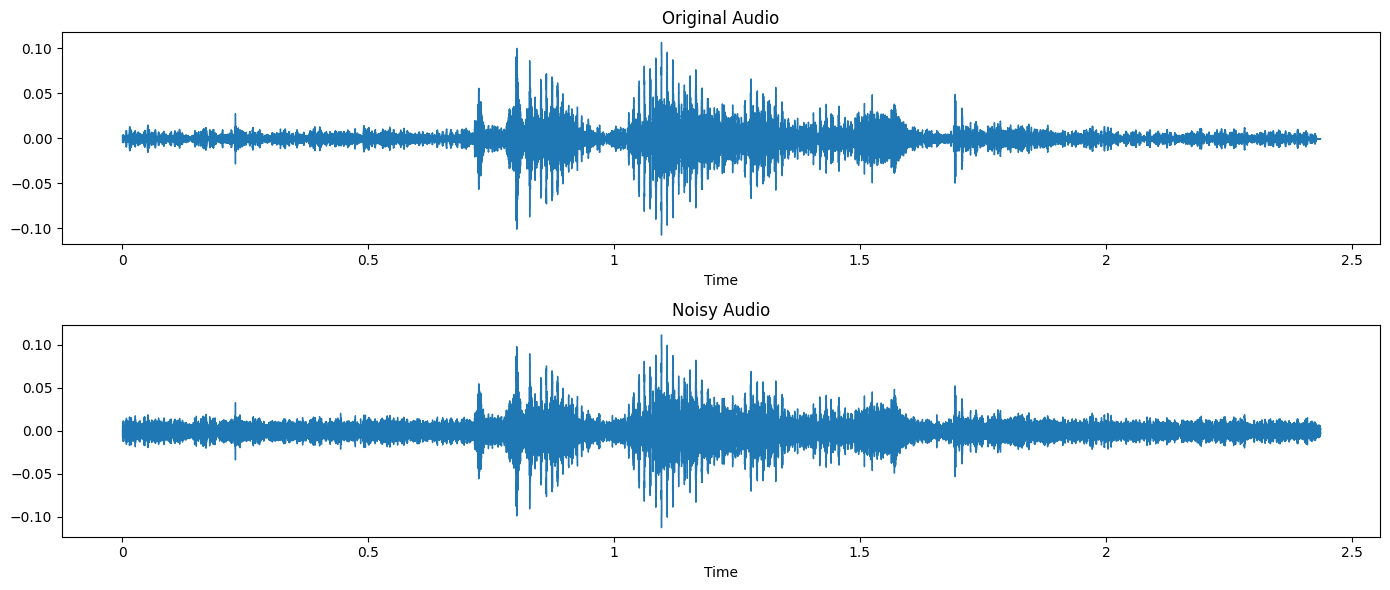

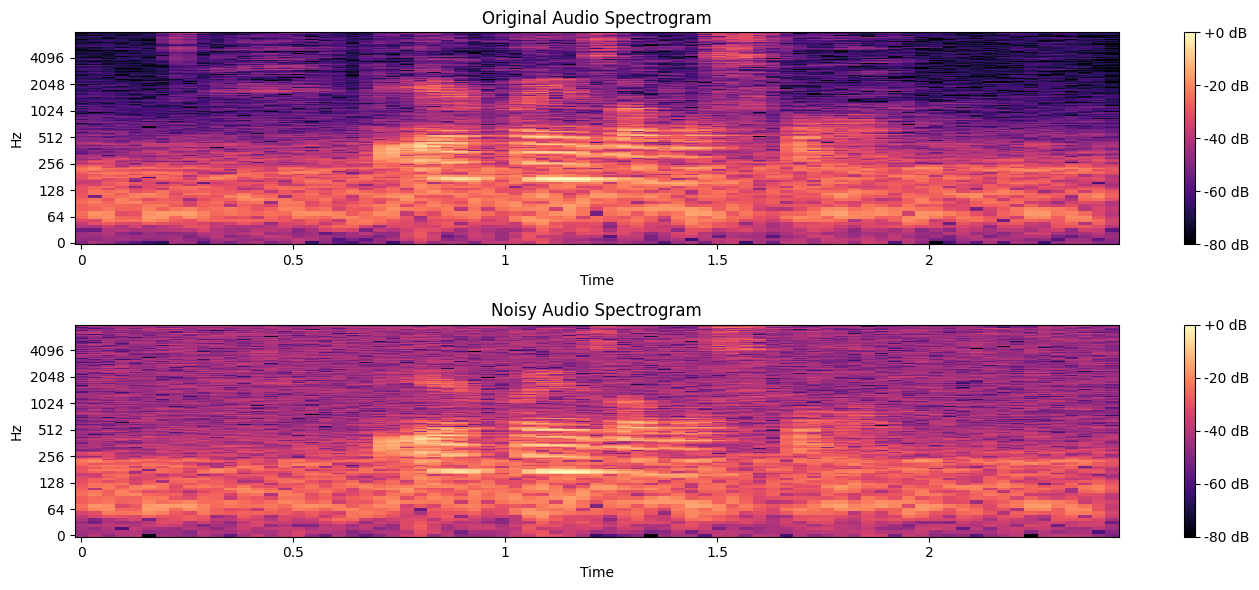

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

class AddGaussianNoise:
    def __init__(self, min_amplitude=0.001, max_amplitude=0.015, p=0.5):
        self.min_amplitude = min_amplitude
        self.max_amplitude = max_amplitude
        self.p = p

    def __call__(self, samples, sample_rate):
        if np.random.rand() < self.p:
            amplitude = np.random.uniform(self.min_amplitude, self.max_amplitude)
            noise = amplitude * np.random.randn(len(samples))
            return samples + noise
        return samples

example_audio_path = train_df['path'][0]
audio, sr = librosa.load(example_audio_path, sr=SAMPLING_RATE)

# 원본 오디오와 노이즈가 추가된 오디오 비교
augment = AddGaussianNoise(p=1.0)  # 항상 노이즈 추가하도록 설정
noisy_audio = augment(samples=audio, sample_rate=sr)

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
librosa.display.waveshow(audio, sr=sr)
plt.title('Original Audio')

plt.subplot(2, 1, 2)
librosa.display.waveshow(noisy_audio, sr=sr)
plt.title('Noisy Audio')

plt.tight_layout()
plt.show()

# 스펙트로그램 비교
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Audio Spectrogram')

plt.subplot(2, 1, 2)
D_noisy = librosa.amplitude_to_db(np.abs(librosa.stft(noisy_audio)), ref=np.max)
librosa.display.specshow(D_noisy, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Noisy Audio Spectrogram')

plt.tight_layout()
plt.show()
